In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [54]:
# Load the dataset
hcho_data = pd.read_csv('preprocessed_dataset/hcho_data.csv')
hcho_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03


In [55]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(hcho_data['HCHO Reading'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on the p-value, decide on stationarity
if adf_test[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")

ADF Statistic: -11.491048
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely stationary.


In [56]:
# Convert 'Current Date' to datetime and set as index
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])
hcho_data.set_index('Current Date', inplace=True)

# Output the first few rows and the index to verify changes
hcho_data_after = hcho_data.head()
hcho_data_info = hcho_data.index

hcho_data_after

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000197,Colombo Proper,2019-01-02
2019-01-01,0.000197,"Deniyaya, Matara",2019-01-02
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02
2019-01-02,0.000263,Colombo Proper,2019-01-03
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03


In [57]:
hcho_data.tail(10)

,HCHO Reading,Location,Next Date
Current Date,,,
2023-12-29,0.000051,"Bibile, Monaragala",2023-12-30
2023-12-29,0.000127,Kurunegala Proper,2023-12-30
2023-12-29,0.000127,Jaffna Proper,2023-12-30
2023-12-30,0.000127,"Bibile, Monaragala",2023-12-31
2023-12-30,0.000158,Kurunegala Proper,2023-12-31
2023-12-30,0.000117,Jaffna Proper,2023-12-31
2023-12-31,0.000117,"Bibile, Monaragala",2024-01-01
2023-12-31,0.000065,Kurunegala Proper,2024-01-01
2023-12-31,0.000065,Jaffna Proper,2024-01-01


In [58]:
hcho_data_info

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-02',
               '2019-01-02', '2019-01-02', '2019-01-03', '2019-01-03',
               '2019-01-03', '2019-01-04',
               ...
               '2023-12-29', '2023-12-29', '2023-12-29', '2023-12-30',
               '2023-12-30', '2023-12-30', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-01-24'],
              dtype='datetime64[ns]', name='Current Date', length=12782, freq=None)

### COLOMBO

In [59]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.636878169720643
p-value: 0.00011039390127992954


In [60]:
# Selecting the data for the model
colombo_data = hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading']
colombo_data

Current Date
2019-01-01    0.000197
2019-01-02    0.000263
2019-01-03    0.000099
2019-01-04    0.000210
2019-01-05    0.000179
                ...   
2023-12-28    0.000228
2023-12-29    0.000140
2023-12-30    0.000140
2023-12-31    0.000080
2022-03-07    0.000254
Name: HCHO Reading, Length: 1826, dtype: float64

In [61]:
# Fit the ARIMA model
arima_model = ARIMA(colombo_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14384.871
Date:                Fri, 19 Apr 2024   AIC                         -28761.742
Time:                        00:55:42   BIC                         -28739.703
Sample:                             0   HQIC                        -28753.612
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.61e-06     21.619      0.000       0.000       0.000
ar.L1          0.8675   2.56e-10   3.39e+09      0.000       0.868       0.868
ma.L1         -0.5930   1.06e-10  -5.61e+09      0.000      -0.593      -0.593
sigma2      8.411e-09   2.23e-10     37.637      0.000    7.97e-09    8.85e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):               143.73
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+26. Standard errors may be unstable.
"""

In [62]:
# Assuming colombo_data has a DateTime index
last_index = colombo_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2024-01-01    0.000166
2024-01-02    0.000163
2024-01-03    0.000161
2024-01-04    0.000158
2024-01-05    0.000156
2024-01-06    0.000154
2024-01-07    0.000153
2024-01-08    0.000152
2024-01-09    0.000150
2024-01-10    0.000149
2024-01-11    0.000149
2024-01-12    0.000148
2024-01-13    0.000147
2024-01-14    0.000147
2024-01-15    0.000146
2024-01-16    0.000146
2024-01-17    0.000145
2024-01-18    0.000145
2024-01-19    0.000145
2024-01-20    0.000145
2024-01-21    0.000144
2024-01-22    0.000144
2024-01-23    0.000144
2024-01-24    0.000144
2024-01-25    0.000144
2024-01-26    0.000144
2024-01-27    0.000144
2024-01-28    0.000143
2024-01-29    0.000143
2024-01-30    0.000143
Freq: D, Name: predicted_mean, dtype: float64

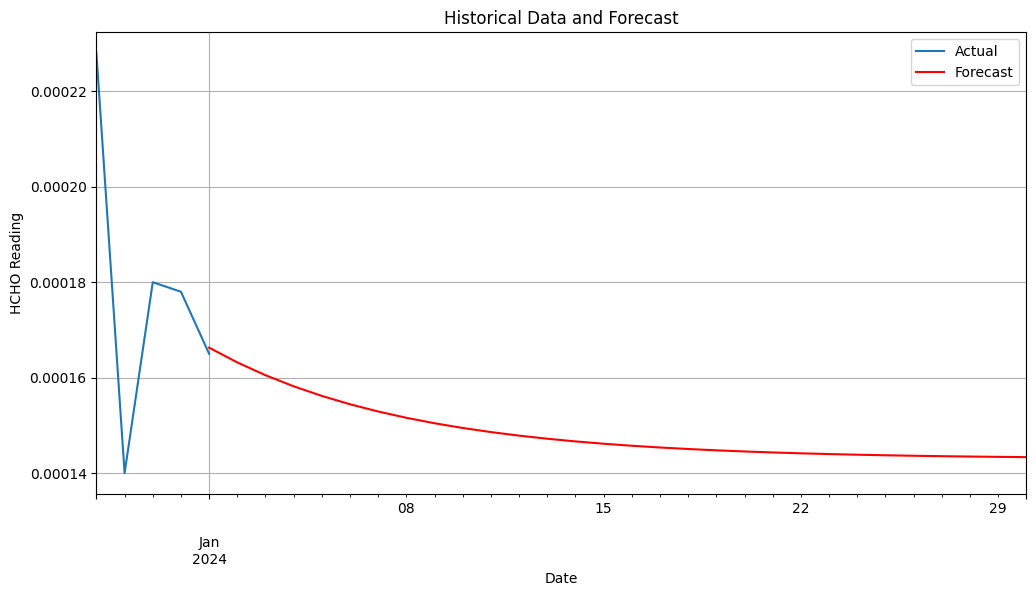

In [63]:
colombo_data = pd.DataFrame({'HCHO Reading': [0.000228, 0.000140, 0.000180, 0.000178, 0.000165]},
                      index=pd.date_range('2023-12-28', periods=5, freq='D'))

# Plotting
plt.figure(figsize=(12, 6))
colombo_data['HCHO Reading'].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### DENIYAYA, MATARA

In [64]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Deniyaya, Matara']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.513802315346827
p-value: 3.951630997438858e-11


In [65]:
# Selecting the data for the model
matara_data = hcho_data[hcho_data['Location'] == 'Deniyaya, Matara']['HCHO Reading']
matara_data

Current Date
2019-01-01    0.000197
2019-01-02    0.000006
2019-01-03    0.000236
2019-01-04    0.000064
2019-01-05    0.000053
                ...   
2023-12-28    0.000228
2023-12-29    0.000140
2023-12-30    0.000116
2023-12-31    0.000080
2022-07-10    0.000029
Name: HCHO Reading, Length: 1826, dtype: float64

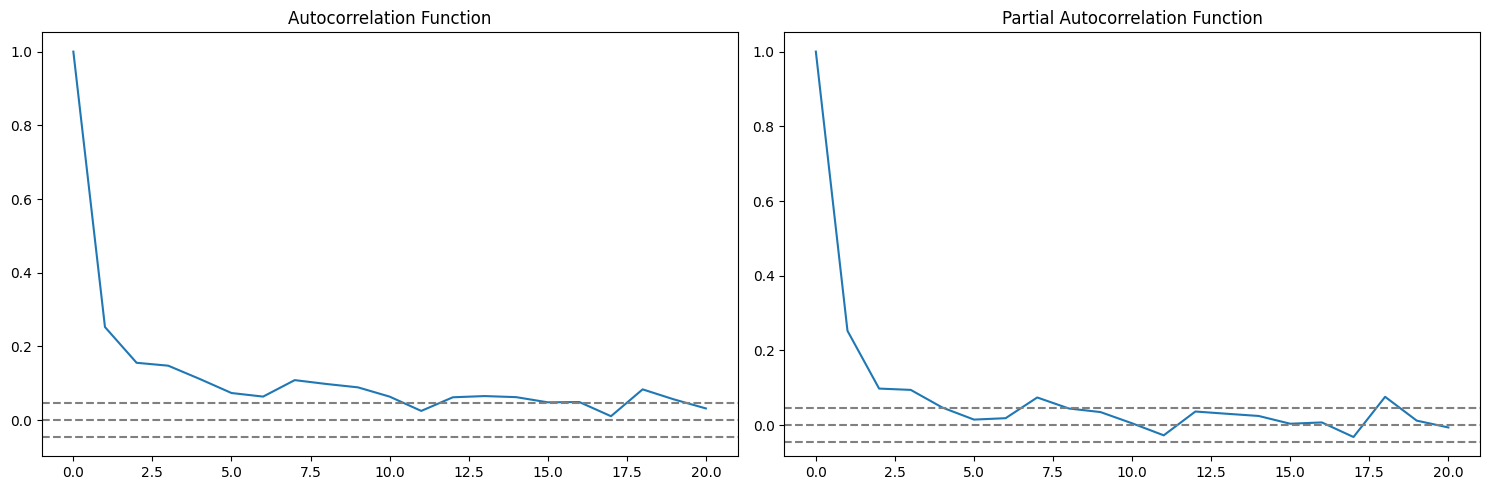

In [66]:
# Calculate ACF and PACF
lag_acf = acf(matara_data, nlags=20)
lag_pacf = pacf(matara_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(matara_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(matara_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(matara_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(matara_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [67]:
# Fit the ARIMA model
arima_model = ARIMA(matara_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14341.727
Date:                Fri, 19 Apr 2024   AIC                         -28675.455
Time:                        00:55:43   BIC                         -28653.415
Sample:                             0   HQIC                        -28667.325
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.88e-06     28.953      0.000       0.000       0.000
ar.L1          0.6827   4.78e-11   1.43e+10      0.000       0.683       0.683
ma.L1         -0.4623   2.49e-11  -1.86e+10      0.000      -0.462      -0.462
sigma2      8.817e-09   2.24e-10     39.343      0.000    8.38e-09    9.26e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               368.58
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.56
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [68]:
# Assuming matara_data has a DateTime index
last_index = matara_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:] 

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2024-01-01    0.000093
2024-01-02    0.000099
2024-01-03    0.000103
2024-01-04    0.000106
2024-01-05    0.000108
2024-01-06    0.000109
2024-01-07    0.000110
2024-01-08    0.000111
2024-01-09    0.000111
2024-01-10    0.000112
2024-01-11    0.000112
2024-01-12    0.000112
2024-01-13    0.000112
2024-01-14    0.000112
2024-01-15    0.000112
2024-01-16    0.000112
2024-01-17    0.000112
2024-01-18    0.000112
2024-01-19    0.000112
2024-01-20    0.000112
2024-01-21    0.000112
2024-01-22    0.000112
2024-01-23    0.000112
2024-01-24    0.000112
2024-01-25    0.000112
2024-01-26    0.000112
2024-01-27    0.000112
2024-01-28    0.000112
2024-01-29    0.000112
2024-01-30    0.000112
Freq: D, Name: predicted_mean, dtype: float64

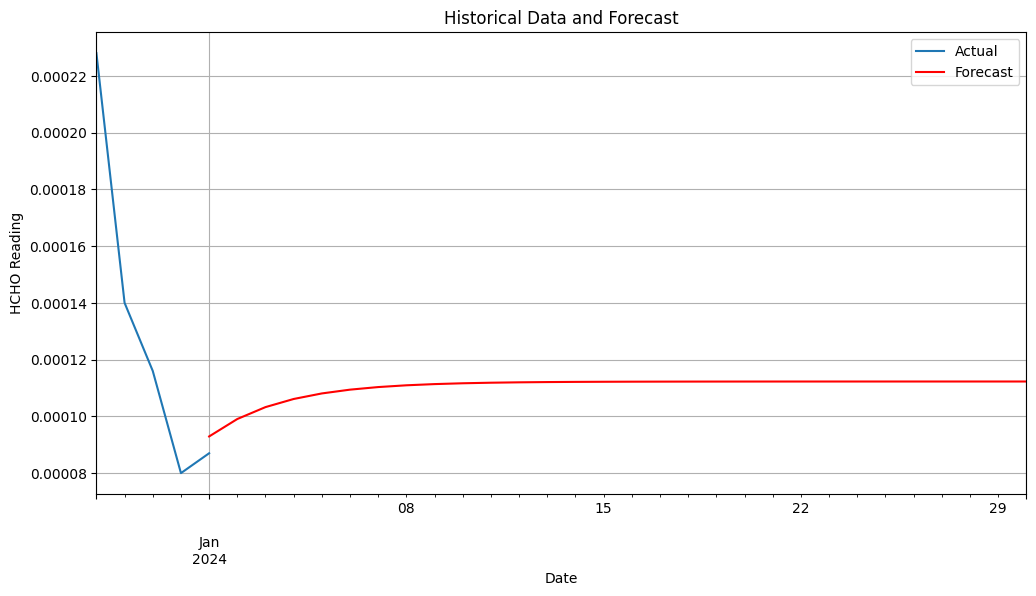

In [69]:
matara_data = pd.DataFrame({'HCHO Reading': [0.000228, 0.000140, 0.000116, 0.000080, 0.000087]},
                      index=pd.date_range('2023-12-28', periods=5, freq='D'))

# Plotting
plt.figure(figsize=(12, 6))
matara_data['HCHO Reading'].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### NUWARA ELIYA

In [70]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Nuwara Eliya Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -20.231828801350492
p-value: 0.0


In [71]:
# Selecting the data for the model
nuwara_eliya_data = hcho_data[hcho_data['Location'] == 'Nuwara Eliya Proper']['HCHO Reading']
nuwara_eliya_data

Current Date
2019-01-01    0.000263
2019-01-02    0.000006
2019-01-03    0.000191
2019-01-04    0.000051
2019-01-05    0.000065
                ...   
2023-12-27    0.000228
2023-12-28    0.000228
2023-12-29    0.000140
2023-12-30    0.000116
2023-12-31    0.000080
Name: HCHO Reading, Length: 1826, dtype: float64

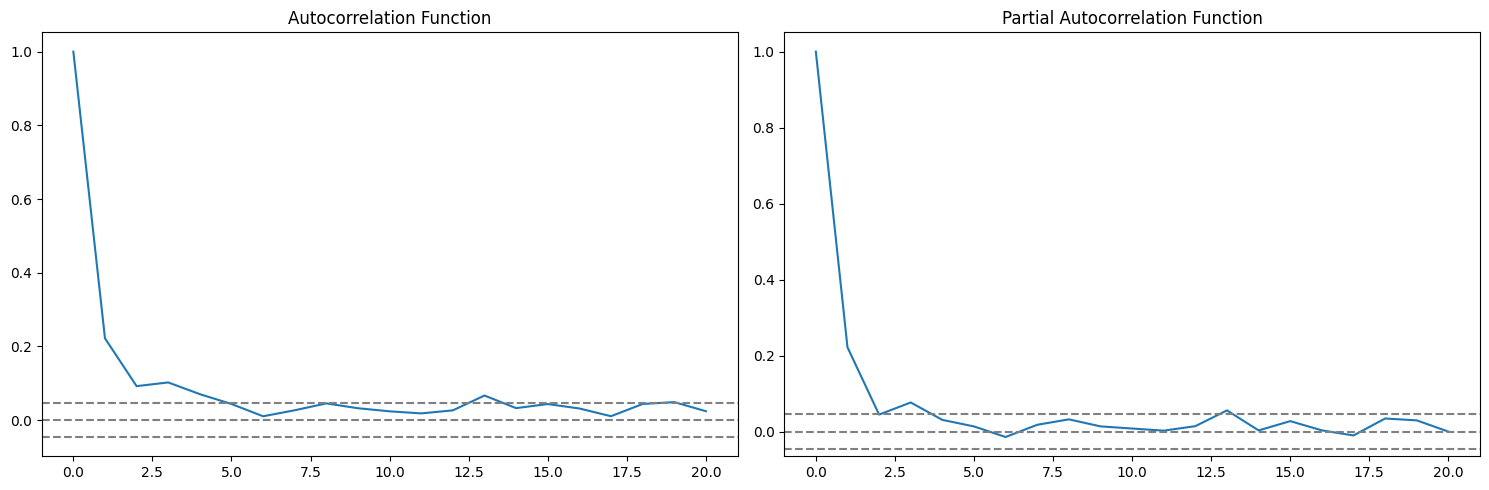

In [72]:
# Calculate ACF and PACF
lag_acf = acf(nuwara_eliya_data, nlags=20)
lag_pacf = pacf(nuwara_eliya_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [73]:
# Fit the ARIMA model
arima_model = ARIMA(nuwara_eliya_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14351.868
Date:                Fri, 19 Apr 2024   AIC                         -28695.737
Time:                        00:55:44   BIC                         -28673.697
Sample:                    01-01-2019   HQIC                        -28687.607
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    3.1e-06     33.476      0.000    9.77e-05       0.000
ar.L1          0.4658    1.9e-11   2.45e+10      0.000       0.466       0.466
ma.L1         -0.2552   1.85e-11  -1.38e+10      0.000      -0.255      -0.255
sigma2      8.716e-09   2.39e-10     36.477      0.000    8.25e-09    9.18e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               146.47
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.35
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [74]:
# Assuming nuwara_eliya_data has a DateTime index
last_index = nuwara_eliya_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2023-12-31    0.000101
2024-01-01    0.000102
2024-01-02    0.000103
2024-01-03    0.000103
2024-01-04    0.000104
2024-01-05    0.000104
2024-01-06    0.000104
2024-01-07    0.000104
2024-01-08    0.000104
2024-01-09    0.000104
2024-01-10    0.000104
2024-01-11    0.000104
2024-01-12    0.000104
2024-01-13    0.000104
2024-01-14    0.000104
2024-01-15    0.000104
2024-01-16    0.000104
2024-01-17    0.000104
2024-01-18    0.000104
2024-01-19    0.000104
2024-01-20    0.000104
2024-01-21    0.000104
2024-01-22    0.000104
2024-01-23    0.000104
2024-01-24    0.000104
2024-01-25    0.000104
2024-01-26    0.000104
2024-01-27    0.000104
2024-01-28    0.000104
2024-01-29    0.000104
Freq: D, Name: predicted_mean, dtype: float64

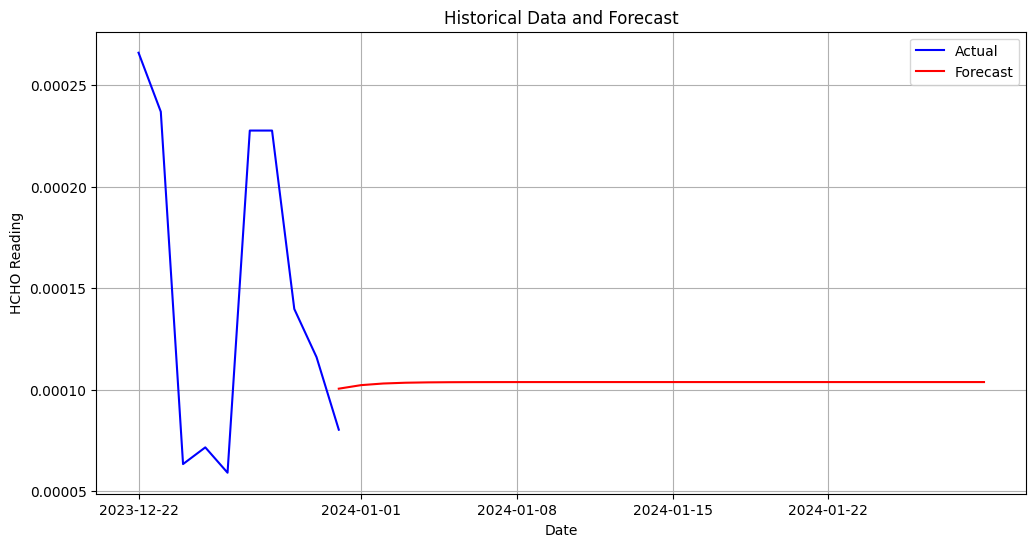

In [75]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nuwara_eliya_data[-10:], label='Actual', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### KANDY

In [76]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Kandy Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -16.57940735318715
p-value: 1.839917148460304e-29


In [77]:
# Selecting the data for the model
kandy_data = hcho_data[hcho_data['Location'] == 'Kandy Proper']['HCHO Reading']
kandy_data

Current Date
2019-01-01    0.000176
2019-01-02    0.000092
2019-01-03    0.000092
2019-01-04    0.000191
2019-01-05    0.000122
                ...   
2023-12-27    0.000056
2023-12-28    0.000056
2023-12-29    0.000056
2023-12-30    0.000056
2023-12-31    0.000056
Name: HCHO Reading, Length: 1826, dtype: float64

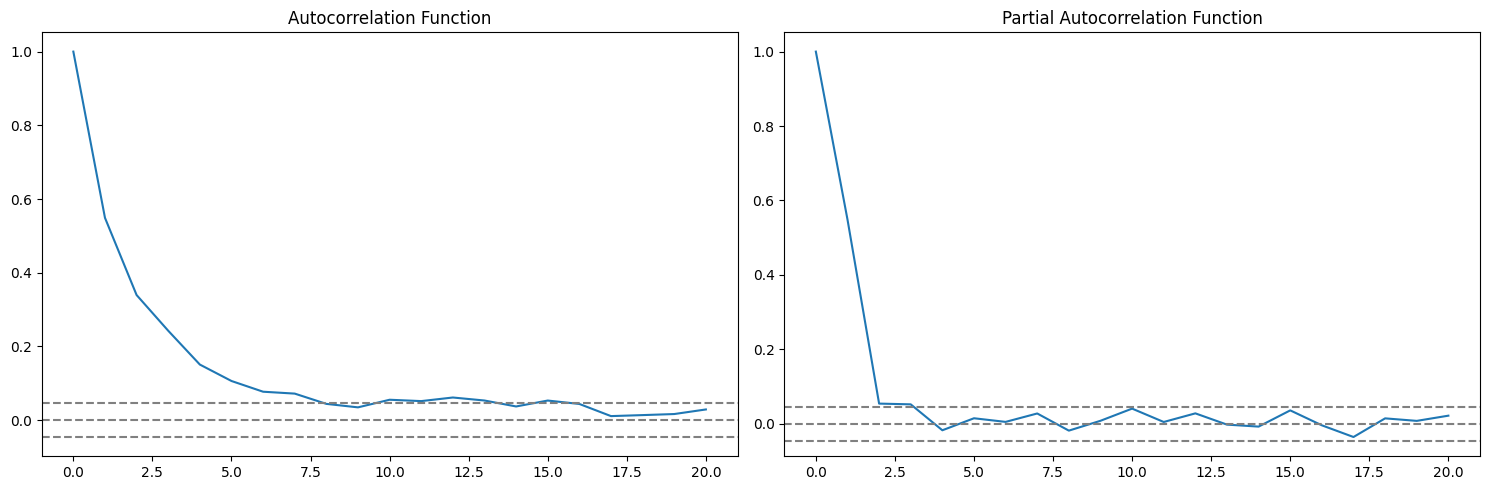

In [78]:
# Calculate ACF and PACF
lag_acf = acf(kandy_data, nlags=20)
lag_pacf = pacf(kandy_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kandy_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kandy_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kandy_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kandy_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [79]:
# Fit the ARIMA model
arima_model = ARIMA(kandy_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15242.297
Date:                Fri, 19 Apr 2024   AIC                         -30476.594
Time:                        00:55:44   BIC                         -30454.555
Sample:                    01-01-2019   HQIC                        -30468.464
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.26e-06     33.486      0.000       0.000       0.000
ar.L1          0.6246   1.59e-10   3.94e+09      0.000       0.625       0.625
ma.L1         -0.1079   7.75e-11  -1.39e+09      0.000      -0.108      -0.108
sigma2      3.288e-09   1.07e-10     30.734      0.000    3.08e-09     3.5e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               139.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.37
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.99e+26. Standard errors may be unstable.
"""

In [80]:
# Assuming kandy_data has a DateTime index
last_index = kandy_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2023-12-31    0.000078
2024-01-01    0.000090
2024-01-02    0.000097
2024-01-03    0.000102
2024-01-04    0.000104
2024-01-05    0.000106
2024-01-06    0.000107
2024-01-07    0.000108
2024-01-08    0.000108
2024-01-09    0.000109
2024-01-10    0.000109
2024-01-11    0.000109
2024-01-12    0.000109
2024-01-13    0.000109
2024-01-14    0.000109
2024-01-15    0.000109
2024-01-16    0.000109
2024-01-17    0.000109
2024-01-18    0.000109
2024-01-19    0.000109
2024-01-20    0.000109
2024-01-21    0.000109
2024-01-22    0.000109
2024-01-23    0.000109
2024-01-24    0.000109
2024-01-25    0.000109
2024-01-26    0.000109
2024-01-27    0.000109
2024-01-28    0.000109
2024-01-29    0.000109
Freq: D, Name: predicted_mean, dtype: float64

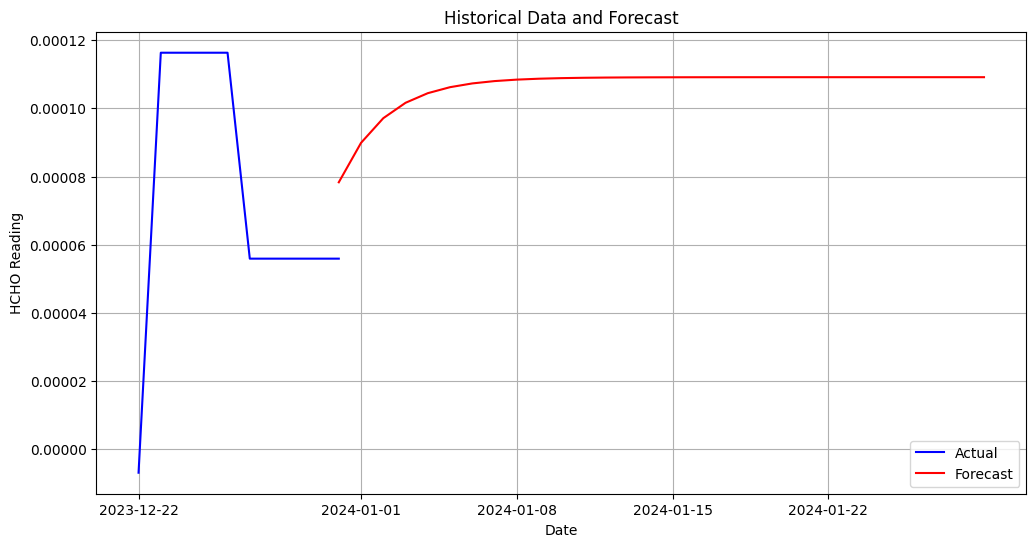

In [81]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(kandy_data[-10:], label='Actual', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### BIBILE

In [105]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Bibile, Monaragala']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.757655331311023
p-value: 2.8446334162236495e-09


In [106]:
# Selecting the data for the model
monaragala_data = hcho_data[hcho_data['Location'] == 'Bibile, Monaragala']['HCHO Reading']
monaragala_data

Current Date
2019-01-01    0.000088
2019-01-02    0.000019
2019-01-03    0.000028
2019-01-04    0.000037
2019-01-05    0.000126
                ...   
2023-12-28    0.000075
2023-12-29    0.000051
2023-12-30    0.000127
2023-12-31    0.000117
2023-01-24    0.000129
Name: HCHO Reading, Length: 1826, dtype: float64

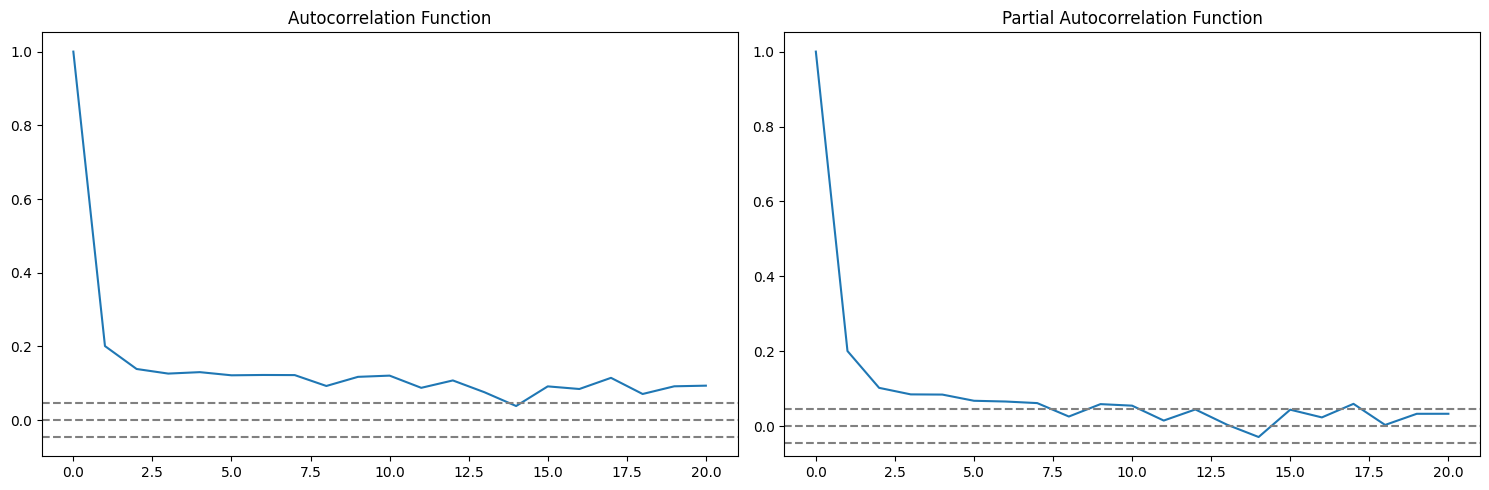

In [101]:
# Calculate ACF and PACF
lag_acf = acf(monaragala_data, nlags=20)
lag_pacf = pacf(monaragala_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monaragala_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monaragala_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [102]:
# Fit the ARIMA model
arima_model = ARIMA(monaragala_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15093.624
Date:                Fri, 19 Apr 2024   AIC                         -30179.249
Time:                        00:58:31   BIC                         -30157.209
Sample:                             0   HQIC                        -30171.119
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.62e-06     49.044      0.000       0.000       0.000
ar.L1          0.7522   4.81e-11   1.56e+10      0.000       0.752       0.752
ma.L1         -0.5823    3.6e-11  -1.62e+10      0.000      -0.582      -0.582
sigma2      3.854e-09   1.56e-10     24.753      0.000    3.55e-09    4.16e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                79.00
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.51
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+25. Standard errors may be unstable.
"""

In [103]:
# Assuming monaragala_data has a DateTime index
last_index = monaragala_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2024-01-01    0.000123
2024-01-02    0.000124
2024-01-03    0.000125
2024-01-04    0.000126
2024-01-05    0.000127
2024-01-06    0.000127
2024-01-07    0.000127
2024-01-08    0.000128
2024-01-09    0.000128
2024-01-10    0.000128
2024-01-11    0.000128
2024-01-12    0.000128
2024-01-13    0.000128
2024-01-14    0.000128
2024-01-15    0.000128
2024-01-16    0.000128
2024-01-17    0.000128
2024-01-18    0.000128
2024-01-19    0.000128
2024-01-20    0.000128
2024-01-21    0.000128
2024-01-22    0.000128
2024-01-23    0.000128
2024-01-24    0.000128
2024-01-25    0.000128
2024-01-26    0.000128
2024-01-27    0.000128
2024-01-28    0.000128
2024-01-29    0.000128
2024-01-30    0.000128
Freq: D, Name: predicted_mean, dtype: float64

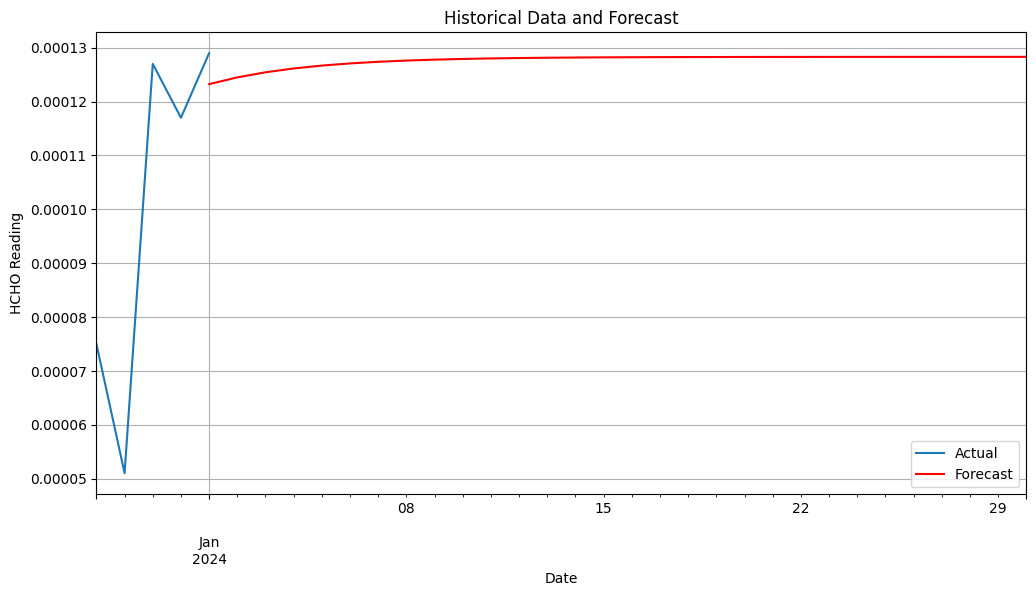

In [107]:
monaragala_data = pd.DataFrame({'HCHO Reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-28', periods=5, freq='D'))

# Plotting
plt.figure(figsize=(12, 6))
monaragala_data['HCHO Reading'].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### KURUNEGALA

In [108]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Kurunegala Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.9732588327915535
p-value: 2.74504620286957e-12


In [109]:
# Selecting the data for the model
kurunegala_data = hcho_data[hcho_data['Location'] == 'Kurunegala Proper']['HCHO Reading']
kurunegala_data

Current Date
2019-01-01    0.000088
2019-01-02    0.000137
2019-01-03    0.000148
2019-01-04    0.000126
2019-01-05    0.000249
                ...   
2023-12-27    0.000075
2023-12-28    0.000051
2023-12-29    0.000127
2023-12-30    0.000158
2023-12-31    0.000065
Name: HCHO Reading, Length: 1826, dtype: float64

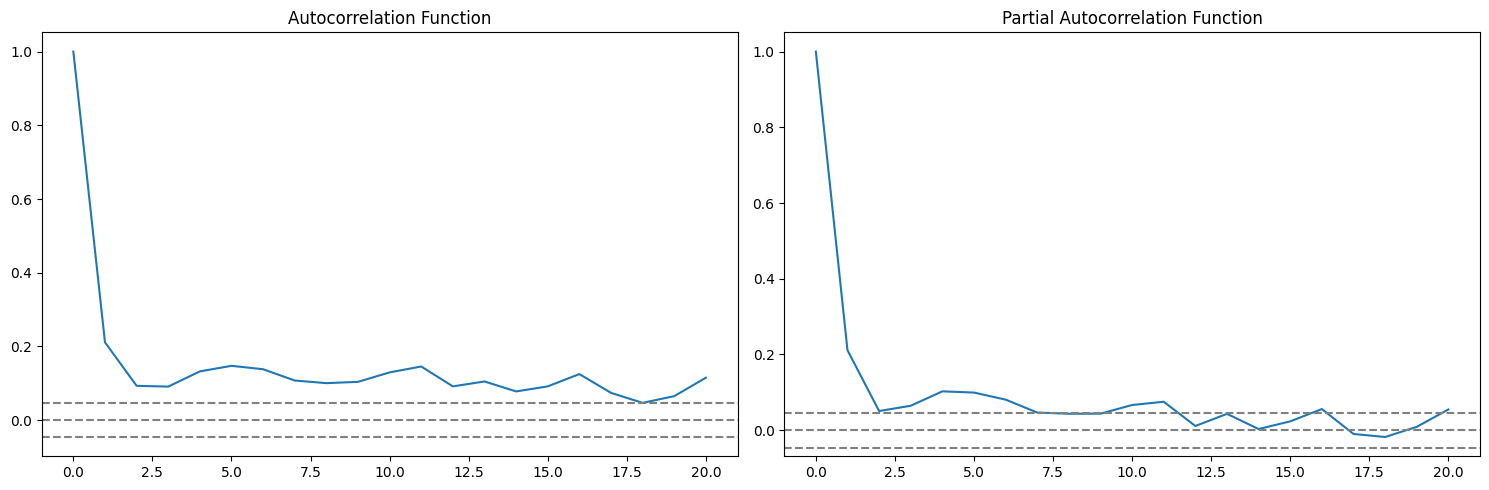

In [110]:
# Calculate ACF and PACF
lag_acf = acf(kurunegala_data, nlags=20)
lag_pacf = pacf(kurunegala_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [111]:
# Fit the ARIMA model
arima_model = ARIMA(kurunegala_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15072.653
Date:                Fri, 19 Apr 2024   AIC                         -30137.307
Time:                        01:05:19   BIC                         -30115.267
Sample:                    01-01-2019   HQIC                        -30129.177
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    2.2e-06     60.280      0.000       0.000       0.000
ar.L1          0.4944   3.85e-11   1.28e+10      0.000       0.494       0.494
ma.L1         -0.2970   3.57e-11  -8.33e+09      0.000      -0.297      -0.297
sigma2       3.96e-09   1.63e-10     24.262      0.000    3.64e-09    4.28e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                77.78
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.50
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [112]:
# Assuming kurunegala_data has a DateTime index
last_index = kurunegala_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2023-12-31    0.000120
2024-01-01    0.000126
2024-01-02    0.000129
2024-01-03    0.000131
2024-01-04    0.000132
2024-01-05    0.000132
2024-01-06    0.000132
2024-01-07    0.000132
2024-01-08    0.000132
2024-01-09    0.000132
2024-01-10    0.000132
2024-01-11    0.000132
2024-01-12    0.000132
2024-01-13    0.000132
2024-01-14    0.000132
2024-01-15    0.000132
2024-01-16    0.000132
2024-01-17    0.000132
2024-01-18    0.000132
2024-01-19    0.000132
2024-01-20    0.000132
2024-01-21    0.000132
2024-01-22    0.000132
2024-01-23    0.000132
2024-01-24    0.000132
2024-01-25    0.000132
2024-01-26    0.000132
2024-01-27    0.000132
2024-01-28    0.000132
2024-01-29    0.000132
Freq: D, Name: predicted_mean, dtype: float64

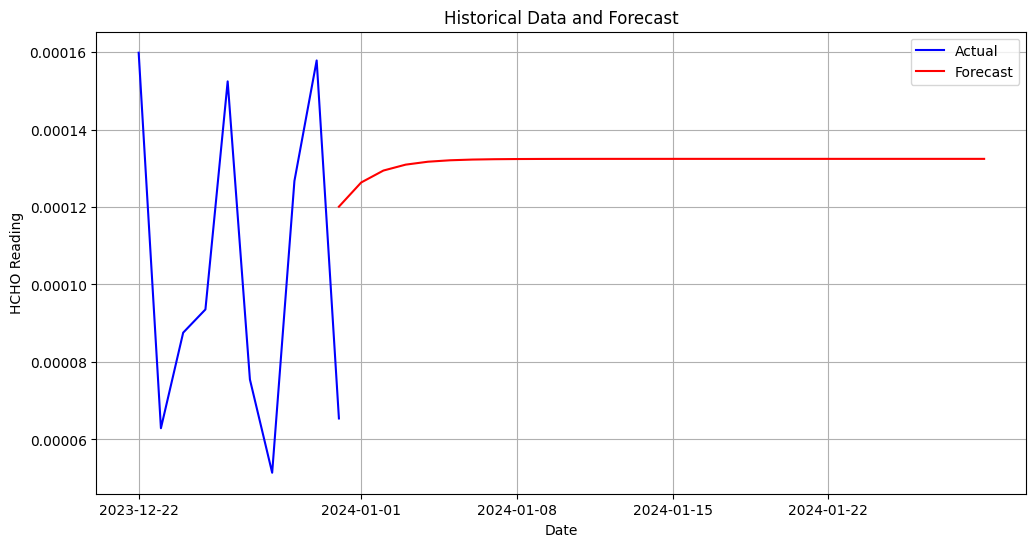

In [113]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(kurunegala_data[-10:], label='Actual', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

### JAFFNA

In [114]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Jaffna Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.616799931928066
p-value: 1.7515970030712004e-16


In [116]:
# Selecting the data for the model
jaffna_data = hcho_data[hcho_data['Location'] == 'Jaffna Proper']['HCHO Reading']
jaffna_data

Current Date
2019-01-01    0.000058
2019-01-02    0.000102
2019-01-03    0.000039
2019-01-04    0.000126
2019-01-05    0.000159
                ...   
2023-12-27    0.000075
2023-12-28    0.000051
2023-12-29    0.000127
2023-12-30    0.000117
2023-12-31    0.000065
Name: HCHO Reading, Length: 1826, dtype: float64

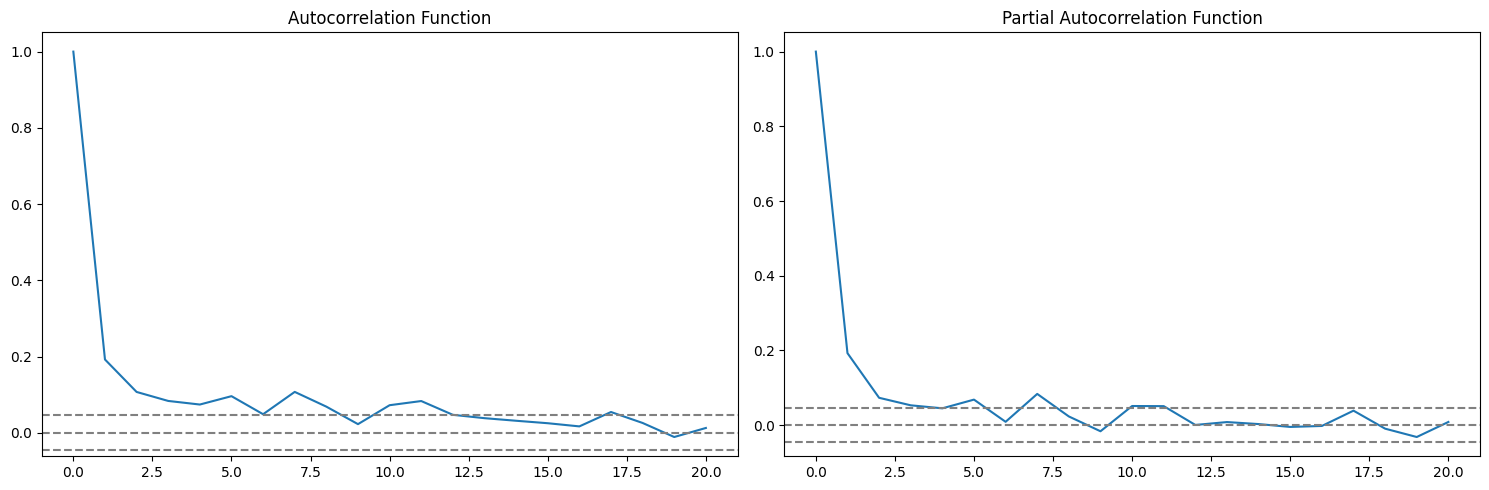

In [117]:
# Calculate ACF and PACF
lag_acf = acf(jaffna_data, nlags=20)
lag_pacf = pacf(jaffna_data, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(jaffna_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(jaffna_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [118]:
# Fit the ARIMA model
arima_model = ARIMA(jaffna_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15246.161
Date:                Fri, 19 Apr 2024   AIC                         -30484.323
Time:                        01:07:54   BIC                         -30462.283
Sample:                    01-01-2019   HQIC                        -30476.193
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    2.1e-06     55.672      0.000       0.000       0.000
ar.L1          0.5968   4.56e-11   1.31e+10      0.000       0.597       0.597
ma.L1         -0.4222   4.05e-11  -1.04e+10      0.000      -0.422      -0.422
sigma2       3.27e-09   1.33e-10     24.637      0.000    3.01e-09    3.53e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               125.84
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.62
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+25. Standard errors may be unstable.
"""

In [119]:
# Assuming jaffna_data has a DateTime index
last_index = jaffna_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2023-12-31    0.000107
2024-01-01    0.000111
2024-01-02    0.000113
2024-01-03    0.000115
2024-01-04    0.000116
2024-01-05    0.000116
2024-01-06    0.000116
2024-01-07    0.000117
2024-01-08    0.000117
2024-01-09    0.000117
2024-01-10    0.000117
2024-01-11    0.000117
2024-01-12    0.000117
2024-01-13    0.000117
2024-01-14    0.000117
2024-01-15    0.000117
2024-01-16    0.000117
2024-01-17    0.000117
2024-01-18    0.000117
2024-01-19    0.000117
2024-01-20    0.000117
2024-01-21    0.000117
2024-01-22    0.000117
2024-01-23    0.000117
2024-01-24    0.000117
2024-01-25    0.000117
2024-01-26    0.000117
2024-01-27    0.000117
2024-01-28    0.000117
2024-01-29    0.000117
Freq: D, Name: predicted_mean, dtype: float64

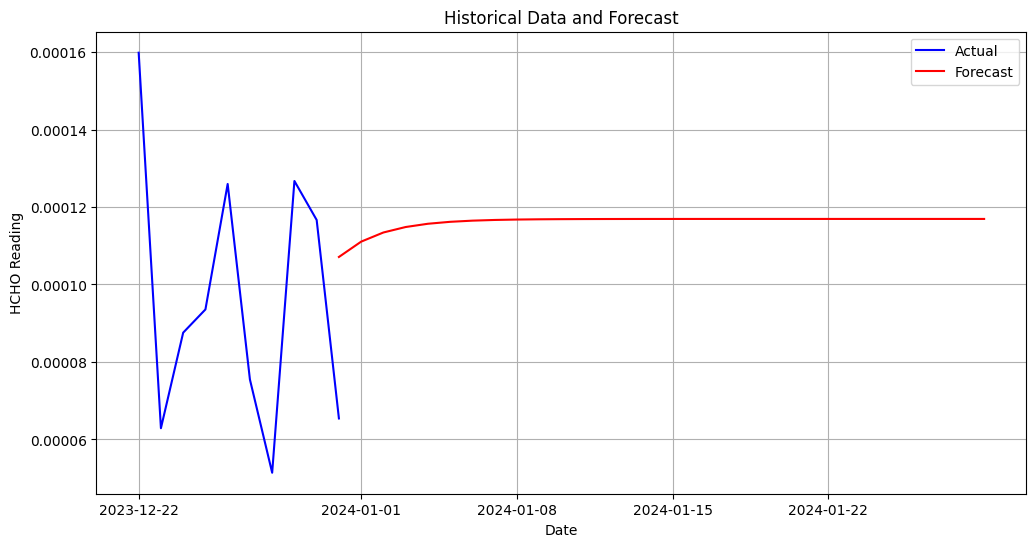

In [120]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(jaffna_data[-10:], label='Actual', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()